In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime


# Result of the Rule Based Detection (main.py):
Number of **Complete** Cases: **9116**

Number of **Finished** Cases: **72622**

Number of **Unfinished** Cases: **27378**

Number of **Expired** Cases: **15576**

Number of **Expired** or **Unfinished** Cases: **27395**

Number of **Finished Complete** Cases: **9116**

In [23]:
output_df = pd.read_csv("../Dataset/Hospital Billing Delta Logs/cases_output_Hospital Billing - Event Log_weekly_(12.csv")

In [24]:
hospital_billing = pd.read_csv('../Dataset/csv/Hospital Billing - Event Log.csv')
print(hospital_billing.columns)
print(f"Length before removing NaN: {len(hospital_billing)}")
hospital_billing_cleaned = hospital_billing.dropna(subset=['case', 'event', 'state'])
print(f"Length after removing NaN: {len(hospital_billing)}")

Index(['case', 'event', 'startTime', 'completeTime', 'isCancelled', 'msgType',
       'diagnosis', 'version', 'caseType', 'actRed', 'speciality',
       'org:resource', 'closeCode', 'blocked', 'isClosed', 'flagD',
       'actOrange', 'flagC', 'flagB', 'flagA', 'msgCount', 'state', 'msgCode'],
      dtype='object')
Length before removing NaN: 451359
Length after removing NaN: 451359


In [25]:
print(len(hospital_billing['event'].unique()))
hospital_billing['event'].unique()

18


array(['NEW', 'FIN', 'RELEASE', 'CODE OK', 'BILLED', 'DELETE', 'REOPEN',
       'CHANGE DIAGN', 'STORNO', 'REJECT', 'CODE NOK', 'SET STATUS',
       'CHANGE END', 'MANUAL', 'JOIN-PAT', 'CODE ERROR', 'ZDBC_BEHAN',
       'EMPTY'], dtype=object)

In [26]:
hospital_billing['state'].unique()

array(['In progress', 'Closed', 'Released', 'Billed', 'Invoice rejected',
       'Billable', 'Empty', 'Unbillable', 'Rejected', 'Check'],
      dtype=object)

In [27]:
hospital_billing['completeTime'] = pd.to_datetime(hospital_billing['completeTime'])

print(f"The number of activities in the event log: {len(hospital_billing)}")
print(f"The number of distinct cases: {len(hospital_billing.groupby('case'))}")
print(f"The timeframe: {hospital_billing.loc[0,'completeTime']} - {hospital_billing.loc[len(hospital_billing)-1,'completeTime']}")
timeframe = (hospital_billing.loc[len(hospital_billing)-1,'completeTime'] - hospital_billing.loc[0,'completeTime'])
print(f"The timeframe is approximately {timeframe.days//365} years and {(timeframe.days % 365) //30} months.")


The number of activities in the event log: 451359
The number of distinct cases: 99999
The timeframe: 2012-12-16 19:33:10 - 2016-01-13 22:48:13
The timeframe is approximately 3 years and 0 months.


## Delta T of Activities

In [57]:
hospital_billing["delta_t"] = hospital_billing.groupby('case')["completeTime"].diff()
delta_t_mean = hospital_billing.groupby('case')['delta_t'].mean()
hospital_billing[["case","event", "delta_t"]]
delta_t_mean

case
A      91 days 20:02:50.250000
AA     38 days 16:30:13.800000
AAA                        NaT
AAAA   25 days 11:10:04.800000
AAAB          20 days 17:31:20
                 ...          
ZZZ    25 days 11:10:08.600000
ZZZA           0 days 03:35:15
ZZZB           0 days 00:00:20
ZZZC                       NaT
ZZZD    5 days 23:08:23.500000
Name: delta_t, Length: 99999, dtype: timedelta64[ns]

### How much time has passed before an event?

In [29]:
time_passed_after_event = hospital_billing.groupby('event')['delta_t'].describe()
time_passed_after_event

,count,mean,std,min,25%,50%,75%,max
event,,,,,,,,
BILLED,67448,34 days 08:48:23.123843553,52 days 08:54:31.858863817,0 days 00:00:00,4 days 07:21:37,8 days 01:02:38,43 days 08:32:01.250000,716 days 23:00:38
CHANGE DIAGN,45451,7 days 18:48:41.302017557,24 days 22:10:09.719228617,0 days 00:00:01,0 days 00:00:18,0 days 00:00:34,0 days 14:49:55,430 days 01:49:03
CHANGE END,38,33 days 06:56:54.763157894,60 days 19:50:55.650826705,0 days 00:00:09,0 days 04:25:40.750000,10 days 09:24:50,39 days 00:30:30.500000,294 days 08:54:25
CODE ERROR,75,3 days 00:37:39.733333333,2 days 14:28:48.301457425,0 days 00:00:02,0 days 01:00:21.500000,3 days 00:02:07,5 days 00:31:43,11 days 11:13:32
CODE NOK,3620,23 days 06:37:56.433425414,63 days 08:39:02.552589838,0 days 00:00:01,1 days 03:17:06.750000,5 days 00:28:14.500000,15 days 01:45:18.750000,571 days 12:39:54
CODE OK,68006,9 days 07:05:16.028968032,45 days 13:03:16.682660020,-1 days +23:42:32,2 days 01:27:52.750000,4 days 00:42:53,5 days 19:14:18,670 days 13:36:46
DELETE,8225,35 days 07:08:58.743951368,77 days 04:24:26.113997630,0 days 00:00:00,0 days 00:34:15,3 days 20:54:46,30 days 13:32:17,662 days 14:05:06
EMPTY,449,0 days 20:45:19.189309576,7 days 21:20:00.386384455,0 days 00:00:02,0 days 03:12:52,0 days 05:10:27,0 days 07:49:31,131 days 03:06:31
FIN,74738,113 days 16:58:05.399314940,115 days 07:07:59.046566726,0 days 00:00:00,42 days 03:13:22.750000,89 days 09:19:54,117 days 21:29:45.750000,527 days 02:58:42


### What is the wait period after the events?

In [59]:
hospital_billing["wait_period"] = hospital_billing.groupby('case')["completeTime"].shift(-1) - hospital_billing["completeTime"]
wait_period_event_stat = hospital_billing.groupby('event')['wait_period'].describe()
wait_period_event_stat
hospital_billing["wait_period"]

0        363 days 23:27:27
1          0 days 08:53:01
2          1 days 09:02:51
3          1 days 14:48:02
4                      NaT
                ...       
416371     8 days 05:41:53
416372     0 days 00:53:23
416373     5 days 16:01:50
416374                 NaT
212                    NaT
Name: wait_period, Length: 451359, dtype: timedelta64[ns]

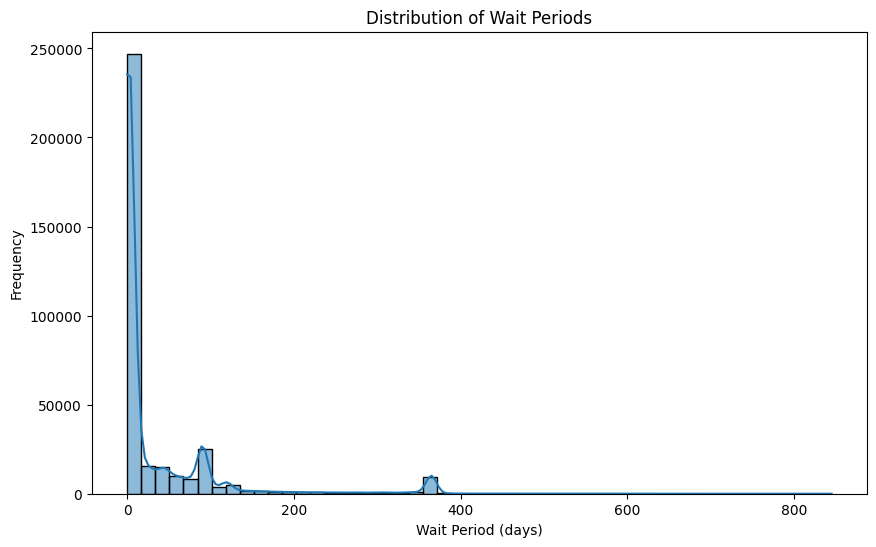

Skewness of the wait period distribution: 3.2511
count    351359.000000
mean         36.248323
std          77.994682
min          -0.012130
25%           0.239323
50%           4.022650
75%          35.139329
max         845.201042
Name: wait_period_days, dtype: float64
95th Percentile Upper Limit: 189.39 days
Upper Limit based on IQR (1.5*IQR above Q3): 87.49 days


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew


# Convert 'wait_period' to a numeric format (in days)
hospital_billing['wait_period_days'] = hospital_billing['wait_period'].dt.total_seconds() / (3600 * 24)  # Convert to days

# Drop NaN values as they represent cases without a valid next event (e.g., the last event in a case)
wait_period_clean = hospital_billing['wait_period_days'].dropna()


# Plot the distribution of wait periods
plt.figure(figsize=(10, 6))
sns.histplot(wait_period_clean, bins=50, kde=True)
plt.title('Distribution of Wait Periods')
plt.xlabel('Wait Period (days)')
plt.ylabel('Frequency')
plt.show()

# Calculate the skewness of the distribution
wait_period_skewness = skew(wait_period_clean)
print(f"Skewness of the wait period distribution: {wait_period_skewness:.4f}")

# Check summary statistics for better understanding
wait_period_stats = wait_period_clean.describe()
print(wait_period_stats)

# Optionally, you can calculate percentiles or IQR as alternative thresholds
percentile_95 = np.percentile(wait_period_clean, 95)
IQR = wait_period_stats['75%'] - wait_period_stats['25%']
upper_limit_IQR = wait_period_stats['75%'] + 1.5 * IQR

print(f"95th Percentile Upper Limit: {percentile_95:.2f} days")
print(f"Upper Limit based on IQR (1.5*IQR above Q3): {upper_limit_IQR:.2f} days")


## Distibution of Event Types

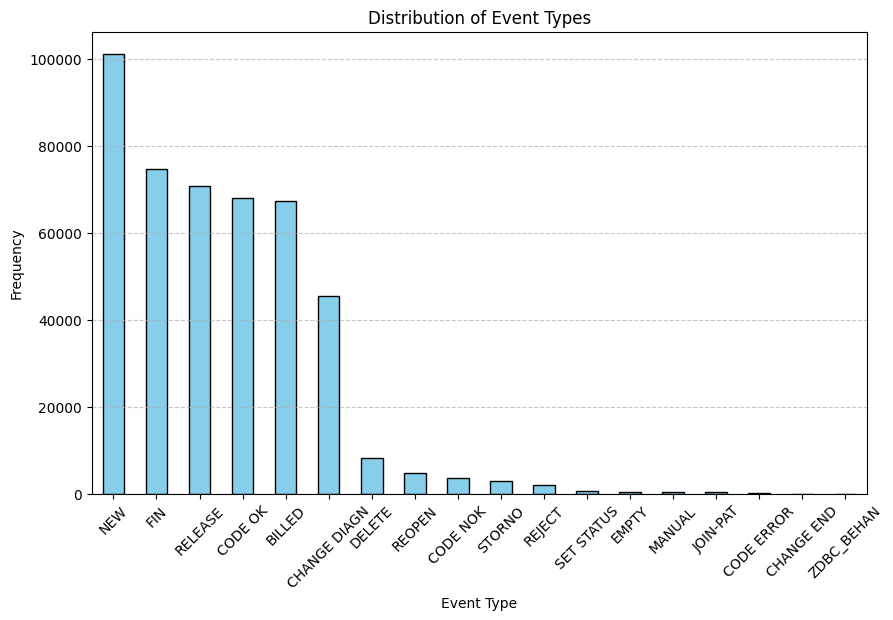

In [31]:
event_counts = hospital_billing['event'].value_counts()

# Plotting the distribution of event types
plt.figure(figsize=(10, 6))
event_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Event Types')
plt.xlabel('Event Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Lengths of Process (#Events)

In [32]:
event_counts = hospital_billing.groupby('case').agg({'event':'count'}).rename(columns={'event': 'event_count'})

low_length_cases = event_counts[event_counts['event_count'] < 4].reset_index()['case']
low_length_events = hospital_billing[hospital_billing['case'].isin(low_length_cases)]
hospital_billing = hospital_billing.merge(event_counts, on='case', how='left')
hospital_billing

,case,event,startTime,completeTime,isCancelled,msgType,diagnosis,version,caseType,actRed,...,actOrange,flagC,flagB,flagA,msgCount,state,msgCode,delta_t,wait_period,event_count
0,A,NEW,2012/12/16 19:33:10.000,2012-12-16 19:33:10,False,NaN,A,NaN,A,NaN,...,NaN,NaN,False,False,NaN,In progress,NaN,NaT,363 days 23:27:27,5.0
1,A,FIN,2013/12/15 19:00:37.000,2013-12-15 19:00:37,False,NaN,A,NaN,A,NaN,...,NaN,NaN,False,False,NaN,Closed,NaN,363 days 23:27:27,0 days 08:53:01,5.0
2,A,RELEASE,2013/12/16 03:53:38.000,2013-12-16 03:53:38,False,NaN,A,NaN,A,NaN,...,NaN,NaN,False,False,NaN,Released,NaN,0 days 08:53:01,1 days 09:02:51,5.0
3,A,CODE OK,2013/12/17 12:56:29.000,2013-12-17 12:56:29,False,NaN,A,A,A,False,...,False,False,False,False,0.0,Released,NaN,1 days 09:02:51,1 days 14:48:02,5.0
4,A,BILLED,2013/12/19 03:44:31.000,2013-12-19 03:44:31,False,NaN,A,A,A,False,...,False,False,False,False,0.0,Billed,NaN,1 days 14:48:02,NaT,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451354,AXQE,NEW,2015/12/13 19:31:23.000,2015-12-13 19:31:23,False,NaN,OM,NaN,A,NaN,...,NaN,NaN,False,False,NaN,In progress,NaN,NaT,NaT,1.0
451355,BXQE,NEW,2016/01/14 21:17:47.000,2016-01-14 21:17:47,False,NaN,NaN,NaN,B,NaN,...,NaN,NaN,False,False,NaN,In progress,NaN,NaT,0 days 00:42:26,2.0
451356,BXQE,DELETE,2016/01/14 22:00:13.000,2016-01-14 22:00:13,True,NaN,NaN,NaN,B,NaN,...,NaN,NaN,False,False,NaN,In progress,NaN,0 days 00:42:26,NaT,2.0
451357,CXQE,NEW,2016/01/11 19:40:47.000,2016-01-11 19:40:47,False,NaN,LL,NaN,A,NaN,...,NaN,NaN,False,False,NaN,In progress,NaN,NaT,NaT,1.0


In [33]:
case_counts_by_event = event_counts.reset_index().groupby('event_count').agg({'case':'count'})
case_counts_by_event

,case
event_count,
1,22372
2,8375
3,1945
4,801
5,22902
6,35154
7,3376
8,919
9,1126


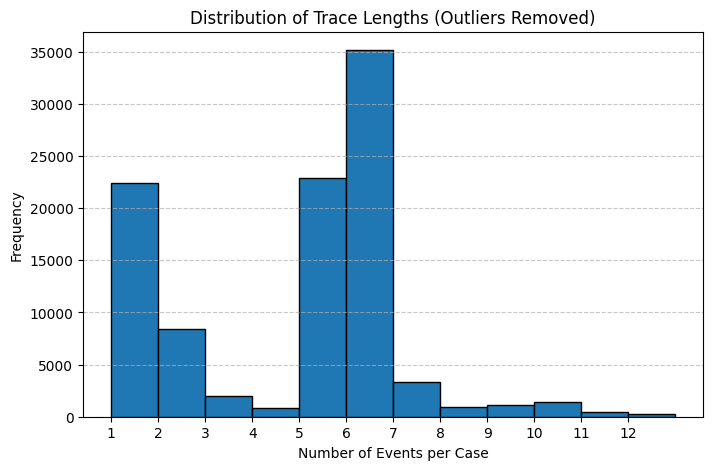

In [34]:
Q1 = event_counts['event_count'].quantile(0.25)
Q3 = event_counts['event_count'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_case_counts = event_counts[(event_counts['event_count'] >= lower_bound) & (event_counts['event_count'] <= upper_bound)]

plt.figure(figsize=(8, 5))
plt.hist(filtered_case_counts['event_count'], bins=range(1, filtered_case_counts['event_count'].max() + 2), edgecolor='black')
plt.xlabel('Number of Events per Case')
plt.ylabel('Frequency')
plt.title('Distribution of Trace Lengths (Outliers Removed)')
plt.xticks(range(1, filtered_case_counts['event_count'].max() + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [35]:
hospital_billing['completeTime'] = pd.to_datetime(hospital_billing['completeTime'])

# Sort by case and completeTime to ensure the last event is correctly identified
hospital_billing = hospital_billing.sort_values(by=['case', 'completeTime'])

# Group by 'case' and get the last event in each group

grouped_hospital = hospital_billing.groupby('case').last().reset_index().rename(columns={'event': 'last_event'})
print(f'Number of cases: {len(grouped_hospital)}')
grouped_hospital.head(25)

Number of cases: 99999


,case,last_event,startTime,completeTime,isCancelled,msgType,diagnosis,version,caseType,actRed,...,actOrange,flagC,flagB,flagA,msgCount,state,msgCode,delta_t,wait_period,event_count
0,A,BILLED,2013/12/19 03:44:31.000,2013-12-19 03:44:31,False,None,A,A,A,False,...,False,False,False,False,0.0,Billed,None,1 days 14:48:02,1 days 14:48:02,5.0
1,AA,BILLED,2013/07/07 19:21:27.000,2013-07-07 19:21:27,False,None,CA,C,B,False,...,False,False,False,False,0.0,Billed,None,139 days 17:37:17,139 days 17:37:17,6.0
2,AAA,NEW,2013/01/26 22:56:11.000,2013-01-26 22:56:11,False,None,None,None,C,None,...,None,None,False,False,NaN,In progress,None,NaT,NaT,1.0
3,AAAA,BILLED,2013/10/24 04:16:56.000,2013-10-24 04:16:56,False,None,JA,D,B,False,...,False,False,False,False,0.0,Billed,None,31 days 20:27:35,31 days 20:27:35,6.0
4,AAAB,BILLED,2014/03/16 22:08:48.000,2014-03-16 22:08:48,False,None,Z,A,B,False,...,False,False,False,False,0.0,Billed,None,7 days 17:08:08,7 days 17:08:08,6.0
5,AAAC,BILLED,2014/10/08 11:18:43.000,2014-10-08 11:18:43,False,None,OB,F,B,False,...,False,False,False,False,0.0,Billed,None,4 days 04:21:37,4 days 04:21:37,6.0
6,AAAD,NEW,2014/12/10 22:49:28.000,2014-12-10 22:49:28,False,None,None,None,I,None,...,None,None,False,False,NaN,In progress,None,NaT,NaT,1.0
7,AAAE,FIN,2015/12/01 20:06:35.000,2015-12-01 20:06:35,False,None,T,None,A,None,...,None,None,False,False,NaN,Empty,None,119 days 18:02:35,119 days 18:02:35,2.0
8,AAB,NEW,2013/01/03 22:55:39.000,2013-01-03 22:55:39,False,None,None,None,C,None,...,None,None,False,False,NaN,In progress,None,NaT,NaT,1.0
9,AABA,BILLED,2013/10/31 11:30:59.000,2013-10-31 11:30:59,False,None,AI,D,B,False,...,False,False,False,False,0.0,Billed,None,12 days 08:08:18,12 days 08:08:18,6.0


In [36]:
# initial_hospital = pd.read_csv('../Dataset/Hospital Billing Delta Logs/Hospital Billing - Event Log_monthly_(12)/Hospital Billing - Event Log_initial_log.csv')
# initial_hospital['completeTime'] = pd.to_datetime(initial_hospital['completeTime'], errors='coerce')
# 
# # Ensure 'case' is a string
# initial_hospital['case'] = initial_hospital['case'].fillna('Unknown').astype(str)
# 
# # Aggregate to get start and end times for each case
# case_durations = initial_hospital.groupby('case').agg(
#     start_time=('completeTime', 'min'),
#     end_time=('completeTime', 'max')
# ).reset_index()
# 
# # Add duration (optional, for understanding)
# case_durations['duration'] = case_durations['end_time'] - case_durations['start_time']
# 
# 
# # sampled_cases = case_durations.sample(frac=0.05, random_state=42)  # Sample #% cases
# plt.figure(figsize=(20, 60))  # Adjust figure size to spread the data
# 
# for i, row in case_durations.iterrows():
#     plt.plot(
#         [row['start_time'], row['end_time']],
#         [row['case'], row['case']],
#         marker='o',
#     )
# 
# plt.title('Sampled General Case Durations', fontsize=16)
# plt.xlabel('Complete Time', fontsize=14)
# plt.ylabel('Case ID', fontsize=14)
# plt.xticks(rotation=45)
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.tight_layout()
# plt.show()


### Case Durations

Number of cases that are finished as soon as started: 22372
The cases: 
2         AAA
6        AAAD
8         AAB
10       AABB
19       AACE
         ... 
99976    ZZVB
99977    ZZVC
99991    ZZYB
99992    ZZYC
99997    ZZZC
Name: case, Length: 22372, dtype: object


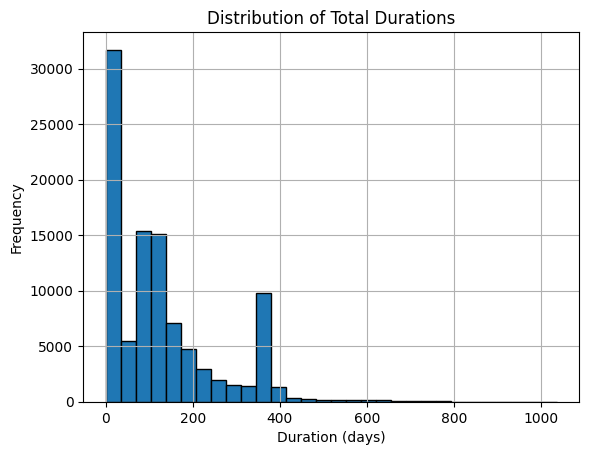

In [37]:
grouped_hospital['trace_start'] = hospital_billing.groupby('case').first().reset_index()['completeTime']
grouped_hospital['trace_end'] = hospital_billing.groupby('case').last().reset_index()['completeTime']
grouped_hospital['trace_duration'] = grouped_hospital['trace_end'] - grouped_hospital['trace_start']

zeroD_zeroH = grouped_hospital[grouped_hospital['trace_duration'] == pd.Timedelta('0 days 00:00:00')]
print(f"Number of cases that are finished as soon as started: {len(zeroD_zeroH)}\nThe cases: \n{zeroD_zeroH['case']}")


durations = grouped_hospital['trace_duration']
durations_in_days = durations.dt.total_seconds() / (24 * 3600)  # Convert to days

# Plot a histogram
plt.hist(durations_in_days, bins=30, edgecolor='black')
plt.title('Distribution of Total Durations')
plt.xlabel('Duration (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The mean duration: 127 days 08:42:44.902159020 
The median duration: 102 days 08:41:57
lower & upper bound: 0 days 00:00:00 & 431 days 02:00:15.500000

After the outliers removed:
The mean duration: 120 days 23:44:55.096713664 
The median duration: 101 days 22:51:45


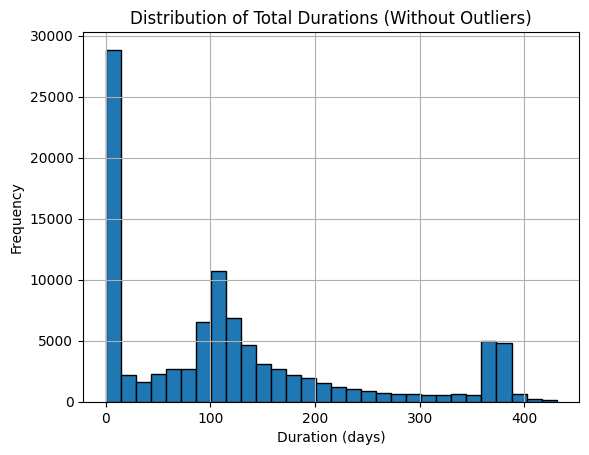

In [38]:
durations = grouped_hospital['trace_duration']
print(f'The mean duration: {durations.mean()} \nThe median duration: {durations.median()}')

Q1 = durations.quantile(0.25)
Q3 = durations.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

if lower_bound<pd.Timedelta('0 days 00:00:00'): lower_bound = pd.Timedelta('0 days 00:00:00')
print(f"lower & upper bound: {lower_bound} & {upper_bound}")

filtered_durations = grouped_hospital[(durations >= lower_bound) & (durations <= upper_bound)]
durations = filtered_durations['trace_duration']
print(f'\nAfter the outliers removed:\nThe mean duration: {durations.mean()} \nThe median duration: {durations.median()}')


durations_in_days = durations.dt.total_seconds() / (24 * 3600)  # Convert to days

# Plot a histogram
plt.hist(durations_in_days, bins=30, edgecolor='black')
plt.title('Distribution of Total Durations (Without Outliers)')
plt.xlabel('Duration (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The mean duration: 164 days 01:02:19.713403056 
The median duration: 123 days 02:14:27.500000


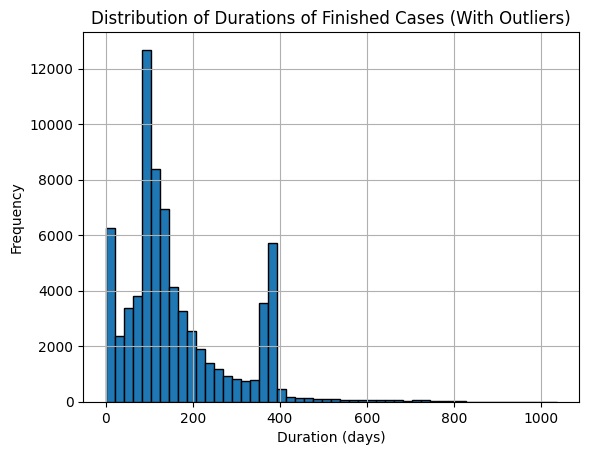

lower & upper bound: 0 days 00:00:00 & 392 days 16:59:10.125000

After the outliers removed:
The mean duration: 154 days 09:29:59.997031426 
The median duration: 120 days 15:34:49


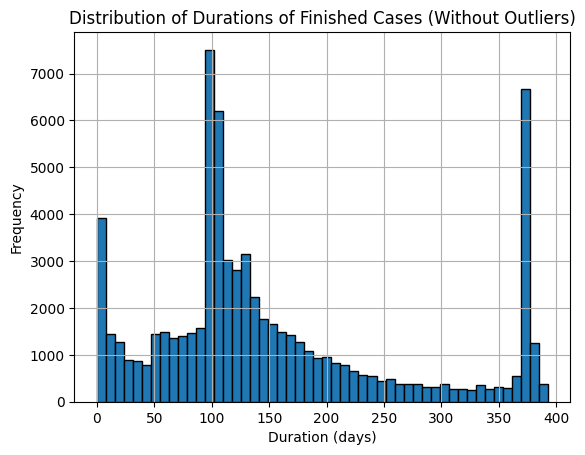

,case,trace_duration,last_event
0,A,367 days 08:11:21,BILLED
1,AA,193 days 10:31:09,BILLED
3,AAAA,127 days 07:50:24,BILLED
4,AAAB,103 days 15:36:40,BILLED
5,AAAC,99 days 19:53:40,BILLED
...,...,...,...
99993,ZZYD,100 days 04:17:24,BILLED
99994,ZZZ,127 days 07:50:43,BILLED
99995,ZZZA,0 days 03:35:15,DELETE
99996,ZZZB,0 days 00:00:40,DELETE


In [39]:
finished_cases = grouped_hospital[(grouped_hospital['state'] == "Billed") | (grouped_hospital['state'] == "Closed") |
                                (grouped_hospital['state'] == "Rejected") | (grouped_hospital['isCancelled'] == True)]

durations = finished_cases['trace_duration']
print(f'The mean duration: {durations.mean()} \nThe median duration: {durations.median()}')

durations_in_days = durations.dt.total_seconds() / (24 * 3600)  # Convert to days
# Plot a histogram
plt.hist(durations_in_days, bins=50, edgecolor='black')
plt.title('Distribution of Durations of Finished Cases (With Outliers)')
plt.xlabel('Duration (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()




Q1 = durations.quantile(0.25)
Q3 = durations.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

if lower_bound<pd.Timedelta('0 days 00:00:00'): lower_bound = pd.Timedelta('0 days 00:00:00')
print(f"lower & upper bound: {lower_bound} & {upper_bound}")

# Filter the finished cases
filtered_durations = finished_cases[(durations >= lower_bound) & (durations <= upper_bound)]

# Extract trace durations without outliers
no_outlier_durations = filtered_durations['trace_duration']

# Print mean and median after removing outliers
print(f'\nAfter the outliers removed:\nThe mean duration: {no_outlier_durations.mean()} \nThe median duration: {no_outlier_durations.median()}')

# Convert durations to days
durations_in_days = no_outlier_durations.dt.total_seconds() / (24 * 3600)

# Plot histogram of durations without outliers
plt.hist(durations_in_days, bins=50, edgecolor='black')
plt.title('Distribution of Durations of Finished Cases (Without Outliers)')
plt.xlabel('Duration (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Display filtered cases
filtered_durations[["case", "trace_duration", "last_event"]]


In [40]:
from datetime import timedelta

# Identify cases with trace duration exceeding the upper bound or median

zeroD_zeroH['time_since_trace_start'] = (
    zeroD_zeroH['completeTime'].max() - zeroD_zeroH['trace_start']
)

# Filter cases where the time since trace_start exceeds the upper bound
unfinished_cases = zeroD_zeroH[
    (zeroD_zeroH['time_since_trace_start'] > upper_bound) &
    (zeroD_zeroH['trace_duration'] == timedelta(0))
]
print(f"Number of unfinished (leftover) cases: {len(unfinished_cases)}")
unfinished_cases[['case', "trace_duration", "time_since_trace_start"]]

Number of unfinished (leftover) cases: 13522


C:\Users\ozndn\AppData\Local\Temp\ipykernel_32904\3912574714.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zeroD_zeroH['time_since_trace_start'] = (


,case,trace_duration,time_since_trace_start
2,AAA,0 days,1085 days 23:59:02
6,AAAD,0 days,403 days 00:05:45
8,AAB,0 days,1108 days 23:59:34
10,AABB,0 days,754 days 00:07:52
20,AAD,0 days,1096 days 23:50:54
...,...,...,...
99975,ZZVA,0 days,767 days 23:58:28
99976,ZZVB,0 days,620 days 00:01:53
99977,ZZVC,0 days,408 days 00:00:39
99991,ZZYB,0 days,599 days 00:05:01


There are 12808 cases that did not have follow up events after the first "New" event. It has been more than the 431 days (upper bound for outliers) since the start of the event till the last event shown in the dataset. 

In [41]:
ongoing_zeroD_zeroH = zeroD_zeroH[
    ~zeroD_zeroH['case'].isin(unfinished_cases['case'])
]

# Display the filtered DataFrame
print(f"Number of completed cases in 0 days: {len(ongoing_zeroD_zeroH)}")
ongoing_zeroD_zeroH[['case', "trace_duration", "time_since_trace_start"]]


Number of completed cases in 0 days: 8850


,case,trace_duration,time_since_trace_start
19,AACE,0 days,157 days 14:18:13
25,AADE,0 days,140 days 00:03:29
43,AAGE,0 days,124 days 00:06:47
49,AAHE,0 days,141 days 14:03:23
54,AAID,0 days,334 days 00:03:44
...,...,...,...
99948,ZZPE,0 days,52 days 00:06:50
99958,ZZRD,0 days,254 days 14:16:38
99963,ZZSD,0 days,242 days 00:08:05
99973,ZZUD,0 days,211 days 00:06:08


### isCancelled 

In [42]:
not_cancelled = grouped_hospital[grouped_hospital['isCancelled'] !=True]
print('Number of cases that are not cancelled: ', len(not_cancelled))
# print(not_cancelled.head())

cancelled_and_notDelete = grouped_hospital[(grouped_hospital['isCancelled']) & (grouped_hospital['last_event'] != 'DELETE')]
print('\nNumber of cases that are Cancelled but the last event is not DELETE: ',len(cancelled_and_notDelete))#, '\nhead of the table:')
# print(cancelled_and_notDelete)


notCancelled_delete = grouped_hospital[(grouped_hospital['isCancelled'] != True) & (grouped_hospital['last_event'] == 'DELETE')]
print('\nNumber of cases that are not Cancelled and the last event is DELETE: ', len(notCancelled_delete))
# print(notCancelled_delete.head())

cancelled_and_Delete = grouped_hospital[(grouped_hospital['isCancelled']) & (grouped_hospital['last_event'] == 'DELETE')]
print('\nNumber of cases that are Cancelled and the last event is DELETE: ', len(cancelled_and_Delete), '\nhead of the table:')
cancelled_and_Delete[cancelled_and_Delete["event_count"] > 2][['case', "event_count"]]



Number of cases that are not cancelled:  91777

Number of cases that are Cancelled but the last event is not DELETE:  7

Number of cases that are not Cancelled and the last event is DELETE:  0

Number of cases that are Cancelled and the last event is DELETE:  8215 
head of the table:


,case,event_count
77,AAMC,3.0
87,AAOA,9.0
176,ABEB,3.0
189,ABGC,4.0
250,ABQD,6.0
...,...,...
99845,ZYYC,3.0
99849,ZYZB,9.0
99901,ZZI,6.0
99908,ZZJA,3.0


### Blocked

In [43]:
blocked = grouped_hospital[grouped_hospital['blocked']]
blocked[['case', 'last_event', 'isCancelled', 'diagnosis', 'version', 'caseType', 'blocked', 'state']]

,case,last_event,isCancelled,diagnosis,version,caseType,blocked,state
5342,BKCA,DELETE,True,DA,D,A,True,Closed
18663,EWCE,MANUAL,False,NL,E,A,True,Billed
27098,HBDD,MANUAL,False,TN,E,B,True,Billed
33853,IUUB,MANUAL,False,BR,E,B,True,Billed
39247,KFGE,CODE OK,False,XA,E,B,True,Billed
40277,KMFE,CODE OK,False,KE,E,B,True,Billed
41441,KUCC,CODE OK,False,OB,E,A,True,Billed
41567,KUYD,CODE OK,False,LKA,E,A,True,Billed
49425,MWBE,CODE OK,False,WD,E,B,True,Billed
56317,OQQD,SET STATUS,False,LE,E,B,True,Unbillable


### actOrange

In [44]:
actOrange = grouped_hospital[grouped_hospital.fillna(False)['actOrange']]
print(actOrange.groupby('state').agg({'case': 'count'}))
grouped_hospital

C:\Users\ozndn\AppData\Local\Temp\ipykernel_32904\329655348.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  actOrange = grouped_hospital[grouped_hospital.fillna(False)['actOrange']]


             case
state            
Billed        120
Empty           1
In progress    11
Released        2
Unbillable      1


,case,last_event,startTime,completeTime,isCancelled,msgType,diagnosis,version,caseType,actRed,...,flagA,msgCount,state,msgCode,delta_t,wait_period,event_count,trace_start,trace_end,trace_duration
0,A,BILLED,2013/12/19 03:44:31.000,2013-12-19 03:44:31,False,None,A,A,A,False,...,False,0.0,Billed,None,1 days 14:48:02,1 days 14:48:02,5.0,2012-12-16 19:33:10,2013-12-19 03:44:31,367 days 08:11:21
1,AA,BILLED,2013/07/07 19:21:27.000,2013-07-07 19:21:27,False,None,CA,C,B,False,...,False,0.0,Billed,None,139 days 17:37:17,139 days 17:37:17,6.0,2012-12-26 08:50:18,2013-07-07 19:21:27,193 days 10:31:09
2,AAA,NEW,2013/01/26 22:56:11.000,2013-01-26 22:56:11,False,None,None,None,C,None,...,False,NaN,In progress,None,NaT,NaT,1.0,2013-01-26 22:56:11,2013-01-26 22:56:11,0 days 00:00:00
3,AAAA,BILLED,2013/10/24 04:16:56.000,2013-10-24 04:16:56,False,None,JA,D,B,False,...,False,0.0,Billed,None,31 days 20:27:35,31 days 20:27:35,6.0,2013-06-18 20:26:32,2013-10-24 04:16:56,127 days 07:50:24
4,AAAB,BILLED,2014/03/16 22:08:48.000,2014-03-16 22:08:48,False,None,Z,A,B,False,...,False,0.0,Billed,None,7 days 17:08:08,7 days 17:08:08,6.0,2013-12-03 06:32:08,2014-03-16 22:08:48,103 days 15:36:40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,ZZZ,BILLED,2013/10/20 04:16:55.000,2013-10-20 04:16:55,False,None,EY,D,B,False,...,False,0.0,Billed,None,31 days 20:27:35,31 days 20:27:35,6.0,2013-06-14 20:26:12,2013-10-20 04:16:55,127 days 07:50:43
99995,ZZZA,DELETE,2014/01/12 11:22:26.000,2014-01-12 11:22:26,True,None,None,None,B,None,...,False,NaN,In progress,None,0 days 03:35:15,0 days 03:35:15,2.0,2014-01-12 07:47:11,2014-01-12 11:22:26,0 days 03:35:15
99996,ZZZB,DELETE,2014/07/01 14:30:41.000,2014-07-01 14:30:41,True,None,BC,None,D,None,...,False,NaN,In progress,None,0 days 00:00:29,0 days 00:00:29,3.0,2014-07-01 14:30:01,2014-07-01 14:30:41,0 days 00:00:40
99997,ZZZC,NEW,2015/01/17 22:49:28.000,2015-01-17 22:49:28,False,None,None,None,I,None,...,False,NaN,In progress,None,NaT,NaT,1.0,2015-01-17 22:49:28,2015-01-17 22:49:28,0 days 00:00:00


### Close Codes:

In [45]:
# Group by last event's  'closeCode', 'last_event', 'state' and get total number of cases for each combination of these.
close_codes =  grouped_hospital.groupby(['closeCode', 'last_event', 'state']).agg('count').reset_index().sort_values(by='case', ascending=False)
sum_cases = close_codes['case'].sum()
print(f'\nTotal Number of cases in close_codes: {sum_cases}\nclose_codes')
close_codes



Total Number of cases in close_codes: 71014
close_codes


,closeCode,last_event,state,case,startTime,completeTime,isCancelled,msgType,diagnosis,version,...,flagB,flagA,msgCount,msgCode,delta_t,wait_period,event_count,trace_start,trace_end,trace_duration
33,C,BILLED,Billed,24325,24325,24325,24325,236,24309,24325,...,24325,24325,24325,236,24325,24325,24325,24325,24325,24325
0,A,BILLED,Billed,15920,15920,15920,15920,60,15902,15920,...,15920,15920,15920,60,15920,15920,15920,15920,15920,15920
17,B,BILLED,Billed,8050,8050,8050,8050,125,8050,8050,...,8050,8050,8050,125,8050,8050,8050,8050,8050,8050
71,E,BILLED,Billed,4458,4458,4458,4458,109,4448,4458,...,4458,4458,4458,109,4458,4458,4458,4458,4458,4458
111,H,FIN,Empty,3563,3563,3563,3563,3,3560,6,...,3563,3563,6,3,3563,3563,3563,3563,3563,3563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,W,JOIN-PAT,Billed,1,1,1,1,0,1,1,...,1,1,1,0,1,1,1,1,1,1
195,W,SET STATUS,Empty,1,1,1,1,0,1,0,...,1,1,0,0,1,1,1,1,1,1
193,W,MANUAL,In progress,1,1,1,1,0,1,0,...,1,1,0,0,1,1,1,1,1,1
201,Y,CODE OK,Billed,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


## isClosed

In [46]:
closed = hospital_billing[hospital_billing['isClosed'] == True][["case", "event", "isClosed", "isCancelled","state"]]
not_closed = closed = hospital_billing[hospital_billing['isClosed'] == False][["case", "event", "isClosed", "isCancelled","state"]]
closed

,case,event,isClosed,isCancelled,state
20304,AAF,NEW,False,False,In progress
20305,AAF,DELETE,False,True,In progress
430237,AAFE,NEW,False,False,In progress
430238,AAFE,DELETE,False,True,In progress
276120,AAGC,NEW,False,False,In progress
...,...,...,...,...,...
172367,ZZZA,NEW,False,False,In progress
172368,ZZZA,DELETE,False,True,In progress
256533,ZZZB,NEW,False,False,In progress
256534,ZZZB,CHANGE DIAGN,False,False,In progress


Closed = False --> Deleted (Closed is only True or only False for all events in the case)
       = True --> Process is finished
	Therefore if a case is closed(True) and there has been some time since that event, then it is probably finished incomplete
 
Cancelled: True --> only True on Delete event (last event)


### Last Event and State:

In [47]:
last_event_state_grouped = grouped_hospital.groupby(['last_event','state']).agg({'case': 'count'}).reset_index().sort_values(by='case', ascending=False)
sum_cases = last_event_state_grouped['case'].sum()
last_event_state_grouped['ratio'] = last_event_state_grouped['case']/sum_cases
print(f'\nTotal Number of cases in last_event_state_grouped: {sum_cases}\n:')
last_event_state_grouped


Total Number of cases in last_event_state_grouped: 99999
:


,last_event,state,case,ratio
0,BILLED,Billed,63498,0.634986
27,NEW,In progress,22406,0.224062
13,DELETE,In progress,7424,0.074241
19,FIN,Empty,3563,0.035630
7,CODE OK,Billed,832,0.008320
31,SET STATUS,Unbillable,458,0.004580
17,EMPTY,Empty,444,0.004440
15,DELETE,Released,281,0.002810
11,DELETE,Closed,228,0.002280
9,DELETE,Billable,214,0.002140


### State of Last Event:

In [48]:
# Group by 'state' (last event's state in the case) and calculate the total number of cases
ratio_of_state = grouped_hospital.groupby(['state']).agg({'case': 'count'}).reset_index().sort_values(by='case', ascending=False)
sum_cases = ratio_of_state['case'].sum()
print(f'\nTotal Number of cases in ratio_of_state: {sum_cases}\nratio_of_state:')
ratio_of_state['ratio'] = ratio_of_state['case']/ratio_of_state['case'].sum()
ratio_of_state


Total Number of cases in ratio_of_state: 99999
ratio_of_state:


,state,case,ratio
1,Billed,64400,0.644006
5,In progress,29855,0.298553
4,Empty,4213,0.042130
7,Released,523,0.005230
8,Unbillable,478,0.004780
3,Closed,276,0.002760
0,Billable,250,0.002500
2,Check,3,0.000030
6,Rejected,1,0.000010


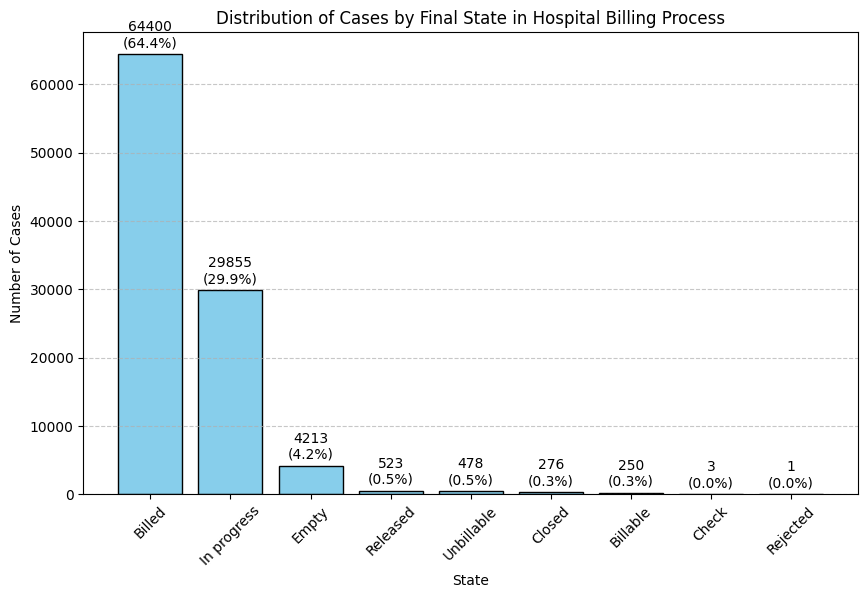

In [49]:
plt.figure(figsize=(10, 6))
plt.bar(ratio_of_state['state'], ratio_of_state['case'], color='skyblue', edgecolor='black')
plt.xlabel('State')
plt.ylabel('Number of Cases')
plt.title('Distribution of Cases by Final State in Hospital Billing Process')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding data labels for both counts and percentages
for index, (value, ratio) in enumerate(zip(ratio_of_state['case'], ratio_of_state['ratio'])):
    plt.text(index, value + 1000, f'{value}\n({ratio:.1%})', ha='center')

plt.show()

### Last event for each case

<Figure size 3200x1000 with 0 Axes>

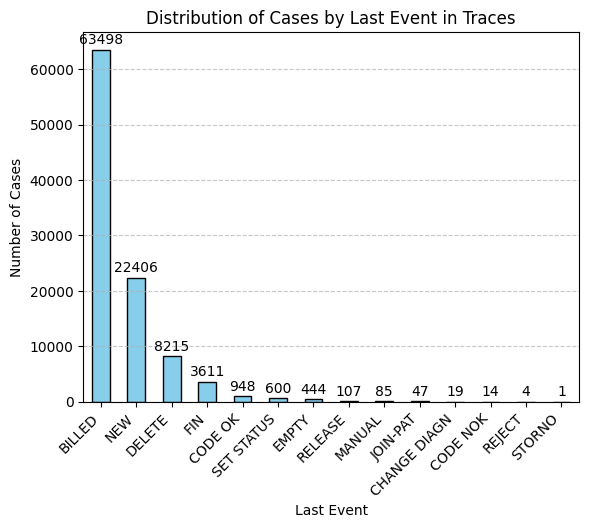

In [50]:
last_event_df = grouped_hospital.groupby(['last_event']).count().sort_values('case',ascending=False)
last_event_df['ratio'] = last_event_df['case'] / last_event_df['case'].sum()
plt.figure(figsize=(32, 10))
last_event_df.reset_index().plot(kind='bar', x='last_event', y='case', color='skyblue', edgecolor='black', legend=False)
plt.title('Distribution of Cases by Last Event in Traces')
plt.xlabel('Last Event')
plt.ylabel('Number of Cases')
plt.xticks(rotation=45, ha='right', fontsize=10)  # Adjust font size for clarity
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding data labels for counts
for index, (value, ratio) in enumerate(zip(last_event_df['case'], last_event_df['ratio'])):
    plt.text(index, value + 1000, f'{value}', ha='center', fontsize=10)  # Adjust font size if needed

plt.show()

### Case Type

In [51]:
case_type = hospital_billing.groupby(['case','caseType'])
case_type.size()


case  caseType
A     A           5
AA    B           6
AAA   C           1
AAAA  B           6
AAAB  B           6
                 ..
ZZZ   B           6
ZZZA  B           2
ZZZB  D           3
ZZZC  I           1
ZZZD  A           5
Length: 101494, dtype: int64

### Gaps or Delays
--> Start time = Complete time

In [52]:
hospital_billing[hospital_billing['startTime'] != hospital_billing['completeTime']]

,case,event,startTime,completeTime,isCancelled,msgType,diagnosis,version,caseType,actRed,...,actOrange,flagC,flagB,flagA,msgCount,state,msgCode,delta_t,wait_period,event_count


### Blocked Cases

In [53]:
blocked = hospital_billing[hospital_billing['blocked']]
blocked

,case,event,startTime,completeTime,isCancelled,msgType,diagnosis,version,caseType,actRed,...,actOrange,flagC,flagB,flagA,msgCount,state,msgCode,delta_t,wait_period,event_count
96661,BKCA,NEW,2013/06/24 05:45:07.000,2013-06-24 05:45:07,False,NaN,DA,NaN,A,NaN,...,NaN,NaN,False,False,NaN,In progress,NaN,NaT,60 days 00:38:29,5.0
96662,BKCA,FIN,2013/08/23 06:23:36.000,2013-08-23 06:23:36,False,NaN,DA,NaN,A,NaN,...,NaN,NaN,False,False,NaN,Closed,NaN,60 days 00:38:29,0 days 01:28:20,5.0
96663,BKCA,RELEASE,2013/08/23 07:51:56.000,2013-08-23 07:51:56,False,NaN,DA,NaN,A,NaN,...,NaN,NaN,False,False,NaN,Released,NaN,0 days 01:28:20,6 days 18:38:53,5.0
96664,BKCA,CODE OK,2013/08/30 02:30:49.000,2013-08-30 02:30:49,False,NaN,DA,D,A,False,...,False,False,False,False,0.0,Released,NaN,6 days 18:38:53,62 days 11:52:36,5.0
96665,BKCA,DELETE,2013/10/31 14:23:25.000,2013-10-31 14:23:25,True,NaN,DA,D,A,False,...,False,False,False,False,0.0,Closed,NaN,62 days 11:52:36,NaT,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131690,ZJNA,CODE OK,2013/11/02 09:32:38.000,2013-11-02 09:32:38,False,W,OB,D,B,False,...,False,False,False,False,0.0,Released,A,0 days 00:06:16,12 days 02:52:54,10.0
131691,ZJNA,BILLED,2013/11/14 12:25:32.000,2013-11-14 12:25:32,False,W,OB,D,B,False,...,False,False,False,False,0.0,Billed,A,12 days 02:52:54,132 days 00:26:18,10.0
131692,ZJNA,MANUAL,2014/03/26 12:51:50.000,2014-03-26 12:51:50,False,W,OB,D,B,False,...,False,False,False,False,0.0,Released,A,132 days 00:26:18,0 days 00:05:35,10.0
131693,ZJNA,CODE OK,2014/03/26 12:57:25.000,2014-03-26 12:57:25,False,W,OB,A,B,False,...,False,False,False,False,0.0,Released,A,0 days 00:05:35,0 days 00:17:37,10.0
